In [2]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
import mlflow
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from sklearn.base import BaseEstimator, TransformerMixin
import torch
from sklearn.manifold import TSNE
import seaborn as sns
import pyLDAvis
import pyLDAvis.lda_model
import time

/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Metriques d'évaluation utilisées
  
  
Perplexity : La perplexité est une mesure de la qualité du modèle. Une perplexité plus faible indique un meilleur modèle. Vous pouvez obtenir ce score en utilisant la méthode perplexity.  
  
Coherence Score : Le score de cohérence mesure la cohérence sémantique des sujets générés par le modèle LDA. Un score de cohérence plus élevé indique que les mots les plus importants d'un sujet sont plus sémantiquement similaires les uns aux autres. Le score de cohérence n'est pas directement disponible dans scikit-learn, mais peut être calculé en utilisant la bibliothèque Gensim.
  
### LDA.  
L'Analyse de la Répartition Latente de Dirichlet (LDA) est une technique de modélisation de sujets qui est largement utilisée en traitement du langage naturel. Elle permet de découvrir les sujets cachés dans un ensemble de documents en attribuant des distributions de probabilité à la fois aux documents (sur les sujets) et aux sujets (sur les mots), ce qui permet d'obtenir une représentation non supervisée et interprétable des données textuelles.



### Lda avec gensim

In [3]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

# Classe de prétraitement
class GensimPreprocessor:
    def __init__(self, stop_words=stopwords.words('english')):
        self.stop_words = stop_words
        
    def tokenize(self, text):
        return [word for word in word_tokenize(text.lower()) if word.isalpha()]
    
    def remove_stopwords(self, tokens):
        return [word for word in tokens if word not in self.stop_words]
    
    def preprocess(self, documents):
        preprocessed = []
        for document in documents:
            tokens = self.tokenize(document)
            tokens = self.remove_stopwords(tokens)
            preprocessed.append(tokens)
        return preprocessed

# Classe pour l'application de LDA de Gensim
class GensimLDA:
    def __init__(self, num_topics=8, passes=10):
        self.num_topics = num_topics
        self.passes = passes
        self.dictionary = None
        self.model = None
        
    def fit(self, documents):
        self.dictionary = Dictionary(documents)
        corpus = [self.dictionary.doc2bow(text) for text in documents]
        self.model = LdaModel(corpus=corpus, id2word=self.dictionary, num_topics=self.num_topics, passes=self.passes, random_state=42)
        
    def get_coherence(self, documents):
        coherence_model = CoherenceModel(model=self.model, texts=documents, dictionary=self.dictionary, coherence='c_v')
        return coherence_model.get_coherence()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aqlice/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def visualize_topics(document_topics, dim_names, document_topics_max):
    # Appliquer t-SNE aux sujets
    tsne_model = TSNE(n_components=2, random_state=0)
    tsne_topics = tsne_model.fit_transform(document_topics)

    # Créer un DataFrame avec les résultats t-SNE et les sujets
    df_tsne = pd.DataFrame(data=tsne_topics, columns=dim_names)
    df_tsne['Topic'] = document_topics_max

    # Créer un graphique de dispersion des sujets avec Seaborn
    plt.figure(figsize=(5, 5))
    sns.scatterplot(x=dim_names[0], y=dim_names[1], hue="Topic", palette="deep", data=df_tsne)
    plt.show()

In [5]:
data = pd.read_csv('Data/df_tags_filtered.csv')
data['combined'] = data['Title'] + " " + data['Body']

display(data[:1])

def words_tokenize(text):
  text = text.split()
  return text

data['Tags'] = data.Tags.apply(lambda text: words_tokenize(text))
display(data[:1])

,Title,Body,Tags,Body_word_count,combined
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,android android-architecture-components bottom...,131,android jetpack navigation bottomnavigationvie...


,Title,Body,Tags,Body_word_count,combined
0,android jetpack navigation bottomnavigationvie...,android jetpack navigation bottomnavigationvie...,"[android, android-architecture-components, bot...",131,android jetpack navigation bottomnavigationvie...


In [6]:
X = data['combined']
y = data['Tags']

from sklearn.model_selection import train_test_split
df = pd.DataFrame(data)

X_train, X_test, y_train, y_test = train_test_split(X,y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (26863,)
X_test shape: (6716,)
y_train shape: (26863,)
y_test shape: (6716,)


## LDA Gensim

train set

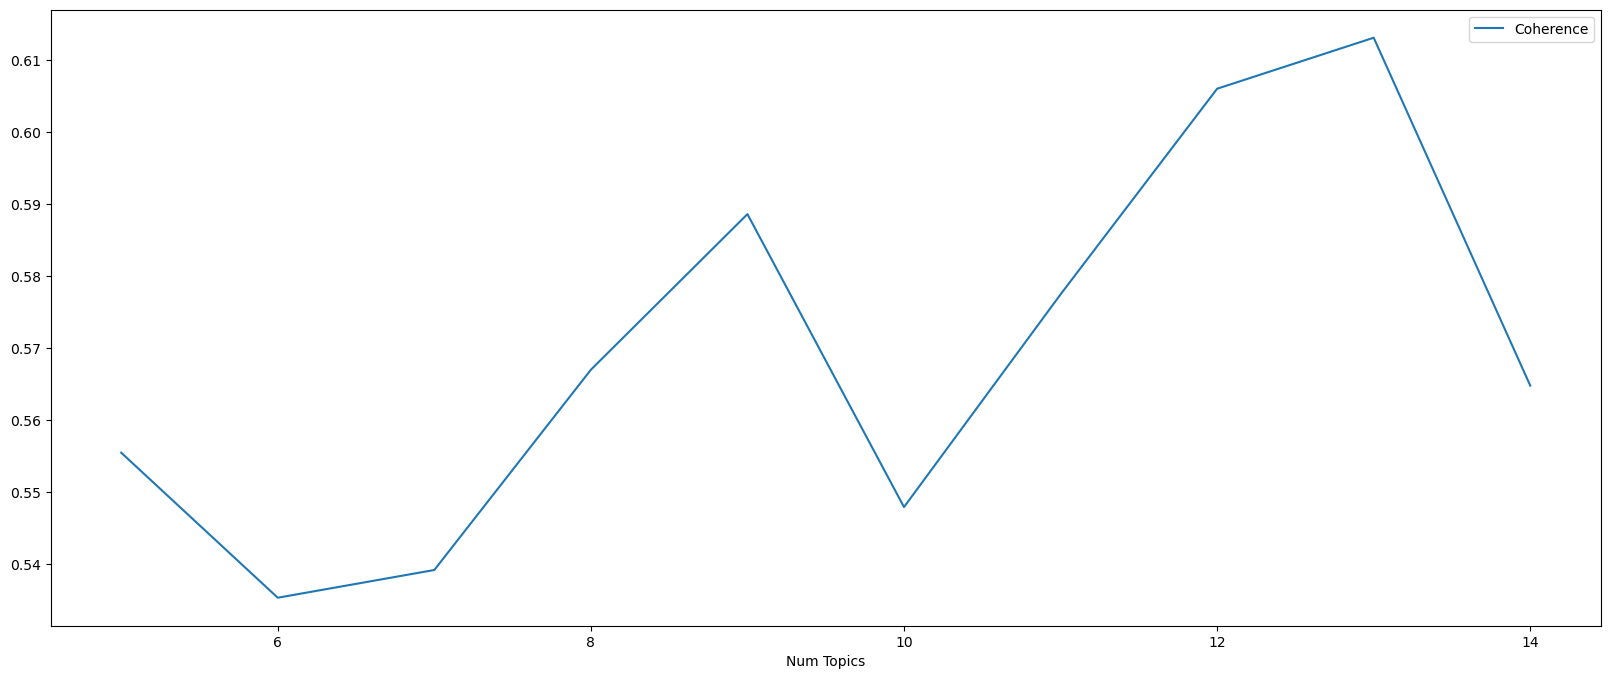

In [36]:
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import time

from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

# Assume 'documents' is your list of documents
documents = X_train

# Preprocess the text data
preprocessor = GensimPreprocessor()
texts = preprocessor.preprocess(documents)

# Create the Dictionary
dictionary = Dictionary(texts)

# Create the Corpus
corpus = [dictionary.doc2bow(text) for text in texts]

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    time_list = []
    for num_topics in range(start, limit, step):
        start_time = time.time()
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        end_time = time.time()
        time_list.append(end_time - start_time)

    return model_list, coherence_values, time_list

# Call the function and plot the results
model_list, coherence_values, time_list = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=5, limit=15, step=1)

x = range(5, 15, 1)
plt.figure(figsize=(20, 8))
plt.plot(x, coherence_values, label='Coherence')
#plt.plot(x, time_list, label='Time')
plt.xlabel("Num Topics")
#plt.ylabel("Coherence score / Time")
plt.legend(loc='best')
plt.show()

In [37]:
# preprocessing
documents =  X_train
preprocessor = GensimPreprocessor()
preprocessed_documents = preprocessor.preprocess(documents)

# LDA
lda = GensimLDA(num_topics=13, passes=10)
lda.fit(preprocessed_documents)

# score de coherence et
coherence_score = lda.get_coherence(preprocessed_documents)
corpus = [lda.dictionary.doc2bow(text) for text in preprocessed_documents]


print("coherence score =",coherence_score)

coherence score = 0.568160963408628


Test set

In [38]:
documents = X_test
preprocessed_test_documents = preprocessor.preprocess(X_test)

# Calcul du score de cohérence sur le set de test
coherence_score_test = lda.get_coherence(preprocessed_test_documents)
print(f"Score de cohérence sur le set de test: {coherence_score_test}")



Score de cohérence sur le set de test: 0.5640283056075049


In [39]:
test_corpus = [lda.dictionary.doc2bow(doc) for doc in preprocessed_test_documents]
test_documents_topics = lda.model.get_document_topics(test_corpus, minimum_probability=0.0)
documents_topics_count_vec = np.array([[prob for _, prob in doc_topics] for doc_topics in test_documents_topics])
document_topics_max = np.argmax(documents_topics_count_vec, axis=1)

In [40]:
import pyLDAvis.gensim_models
import pyLDAvis
# Assurez-vous d'appeler pyLDAvis.enable_notebook() dans un environnement Jupyter pour l'interaction inline
pyLDAvis.enable_notebook()

# Préparation des données pour PyLDAVis
vis = pyLDAvis.gensim_models.prepare(lda.model, test_corpus, dictionary=lda.dictionary)

# Visualisation
pyLDAvis.display(vis)

In [41]:
# obtain topic distributions for each document
topic_dist = pd.DataFrame(test_documents_topics)
for topic in topic_dist.columns:
    topic_dist[topic] = topic_dist[topic].apply(lambda x : x[1])

print('matrix of document/topic distribution shape:', topic_dist.shape)
display(topic_dist.head())


matrix of document/topic distribution shape: (6716, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.601030,0.039444,0.000987,0.000987,0.074178,0.000987,0.276463,0.000987,0.000987,0.000987,0.000987,0.000987,0.000987
1,0.701057,0.064930,0.001306,0.001306,0.150710,0.001306,0.036159,0.036698,0.001306,0.001306,0.001306,0.001306,0.001306
2,0.152428,0.276043,0.001000,0.123265,0.054969,0.001000,0.087733,0.081934,0.001000,0.152763,0.001000,0.001000,0.065865
3,0.728320,0.000876,0.000876,0.000876,0.012058,0.150281,0.101455,0.000876,0.000876,0.000876,0.000876,0.000876,0.000876
4,0.093217,0.017299,0.000658,0.255060,0.000658,0.000658,0.526088,0.000658,0.008860,0.039150,0.029138,0.027896,0.000658


In [61]:

from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer()

# Adapter MultiLabelBinarizer et transformer les étiquettes
y_test_binarized = mlb.fit_transform(y_test)


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier


time1 =time.time()
x_train, x_test, y_train_lr, y_test_lr = train_test_split(topic_dist, y_test_binarized, test_size=0.2, random_state=100)
lr = OneVsRestClassifier(LogisticRegression()).fit(x_train, y_train_lr)
y_pred_lr = lr.predict_proba(x_test)
fit_time = np.round(time.time() - time1,1)
#score of prediction



/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 16 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 38 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 46 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/sklearn/multiclass.py:84: UserWarning: Label not 51 is present in all training examples.
  warnings.warn(
/opt/anaconda3/envs/real

In [75]:
probabilities = y_pred_lr

# Définir un seuil personnalisé pour sélectionner les tags
threshold = 0.15  # baisser le seuil pour inclure plus de tags

def select_top_n_tags(probabilities, threshold, top_n=5):
    # Créer une matrice de zéros de la même forme que probabilities
    final_tags = np.zeros(probabilities.shape)
    
    for i in range(probabilities.shape[0]):
        # Trouver les indices qui satisfont le seuil
        eligible_indices = np.where(probabilities[i] >= threshold)[0]
        
        # Trier ces indices en fonction de leur probabilité
        top_indices = eligible_indices[np.argsort(probabilities[i][eligible_indices])][::-1]
        
        # Sélectionner les top N indices
        top_n_indices = top_indices[:top_n]
        
        # Mettre à 1 les positions correspondant aux tags sélectionnés
        final_tags[i, top_n_indices] = 1
    
    return final_tags

# Utiliser la fonction pour obtenir les tags prédits

binary_predictions = select_top_n_tags(probabilities, threshold, top_n=7)

In [76]:
from sklearn.metrics import jaccard_score


print("jaccord score:", jaccard_score(binary_predictions, y_test_lr, average='samples'))
print("Precision:", precision_score(binary_predictions, y_test_lr, average='samples'))
print("Recall:", recall_score(binary_predictions, y_test_lr, average='samples'))
print("F1 Score:", f1_score(binary_predictions, y_test_lr, average='samples'))


jaccord score: 0.1583951494107744
Precision: 0.2115079365079365


/opt/anaconda3/envs/realboa/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.3662308673469387
F1 Score: 0.25082172704940564


In [77]:
# Afficher les labels des prédictions
predictions_labels = mlb.inverse_transform(binary_predictions)
true_labels = mlb.inverse_transform(y_test_lr)
print(predictions_labels)
print(true_labels)

[('c#', 'c++', 'java', 'python'), ('c++', 'java', 'python'), ('sql', 'sql-server', 'sql-server-2008'), ('c#', 'java'), ('android', 'c#'), ('android', 'c#'), ('c#', 'python'), ('javascript', 'python'), ('android', 'android-activity', 'android-fragments', 'android-layout', 'android-recyclerview'), ('c#', 'c++', 'java', 'javascript', 'python'), ('javascript',), ('android', 'android-studio', 'java'), ('c#', 'javascript'), ('python',), ('c#', 'javascript'), ('javascript',), ('sql', 'sql-server'), ('c#', 'c++', 'java', 'javascript', 'python'), ('javascript',), ('android', 'c#', 'java'), ('android', 'c#', 'javascript'), ('android', 'android-gradle-plugin', 'android-studio', 'gradle', 'java'), ('android',), ('c#', 'c++', 'java', 'javascript', 'python'), ('c#',), ('c#', 'java'), ('c#', 'javascript', 'python'), (), ('c#', 'java'), ('python',), ('c#', 'java'), ('android', 'java'), ('javascript',), ('android', 'android-fragments', 'android-layout', 'android-recyclerview'), ('c#', 'java', 'javascri

In [78]:


# Créer un DataFrame à partir des labels de prédiction et des vrais labels
df = pd.DataFrame({
    'Predicted Labels': predictions_labels,
    'True Labels': true_labels
})

display(df)

,Predicted Labels,True Labels
0,"(c#, c++, java, python)","(abstract-class, arrays, c#, pass-by-reference)"
1,"(c++, java, python)","(c++, exponentiation, integer-overflow, modulo)"
2,"(sql, sql-server, sql-server-2008)","(database, geocoding, latitude-longitude, sql)"
3,"(c#, java)","(firebase, google-cloud-firestore, javascript)"
4,"(android, c#)","(android, android-2.2-froyo, android-service, ..."
...,...,...
1339,"(android, android-fragments, android-layout, j...","(android, android-button, android-layout, andr..."
1340,"(c#, java)","(cocoa, compilation, compiler-errors, objectiv..."
1341,"(c#, java)","(annotations, autowired, java, spring, spring-..."
1342,"(python,)","(dictionary, grouping, list, python, reorganize)"
